In [1]:
# import standard libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import ast 
import json

In [2]:
task_summary = pd.read_csv('../Data/task_summary.csv')

In [3]:
task_summary.head()

,task_label,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights,test_input_width,test_input_height,test_output_width,test_output_height,unique_colors
0,007bbfb7.json,5,"[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[9, 9, 9, 9, 9]","[9, 9, 9, 9, 9]",[3],[3],[9],[9],"[0, 2, 4, 6, 7]"
1,00d62c1b.json,5,"[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]",[20],[20],[20],[20],"[0, 3, 4]"
2,017c7c7b.json,3,"[3, 3, 3]","[6, 6, 6]","[3, 3, 3]","[9, 9, 9]",[3],[6],[3],[9],"[0, 1, 2]"
3,025d127b.json,2,"[9, 9]","[14, 8]","[9, 9]","[14, 8]",[10],[10],[10],[10],"[0, 2, 4, 6, 8]"
4,045e512c.json,3,"[21, 21, 21]","[21, 21, 21]","[21, 21, 21]","[21, 21, 21]",[21],[21],[21],[21],"[0, 1, 2, 3, 4, 5, 6, 8]"


In [4]:
task_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
task_label              400 non-null object
num_train               400 non-null int64
train_input_widths      400 non-null object
train_input_heights     400 non-null object
train_output_widths     400 non-null object
train_output_heights    400 non-null object
test_input_width        400 non-null object
test_input_height       400 non-null object
test_output_width       400 non-null object
test_output_height      400 non-null object
unique_colors           400 non-null object
dtypes: int64(1), object(10)
memory usage: 34.5+ KB


In [5]:
exclude_cols = ['task_label', 'num_train']
list_cols = [col for col in task_summary.columns if col not in exclude_cols]

# convert objects within columns containing lists from strings to lists
for col in list_cols:
    task_summary[col] = task_summary[col].apply(ast.literal_eval)

# Analysis

In order to gain a better understanding of the data, we will do some visualizations and exploratory analysis.


## Training Sizes
First we will determine the distribution of the number of training samples in each task. 

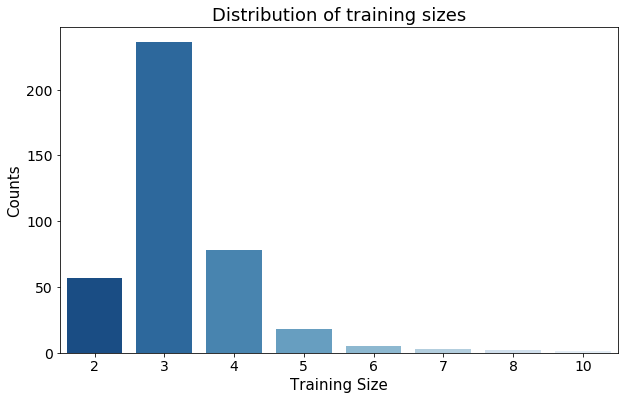

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(task_summary.num_train, palette='Blues_r')
ax.grid(False)
ax.set_xlabel('Training Size', size=15) 
ax.set_ylabel('Counts', size=15)
ax.set_title('Distribution of training sizes', size=18);

ax.tick_params(axis='both', which='major', labelsize=14)

We find that the majority of the tasks(over 50%) contain three training samples, with four and two following right after. None of the tasks have 9 training samples, and very few contain more than 5 training samples.


## Unique colors in training set 

We will not see if a specific color is related to a training size. We do this by first grouping the data based on the size of its training set, and then retrieving the count of unique colors occuring in each group. 

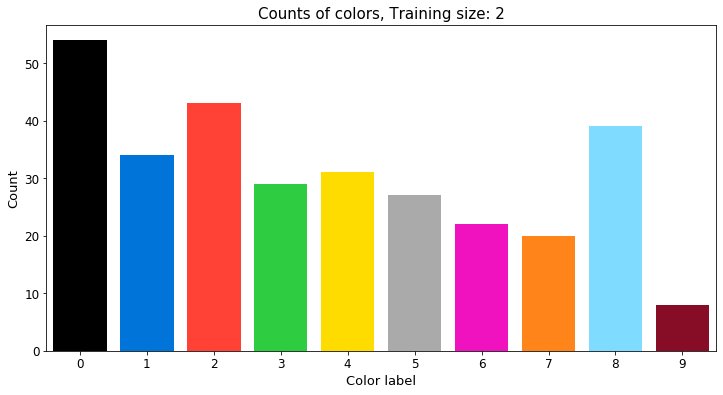

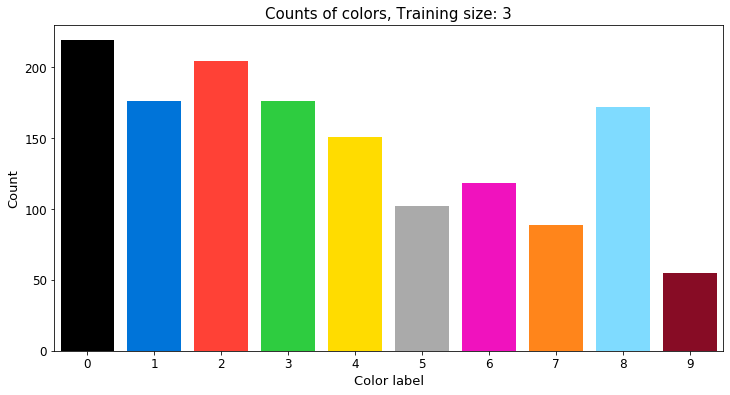

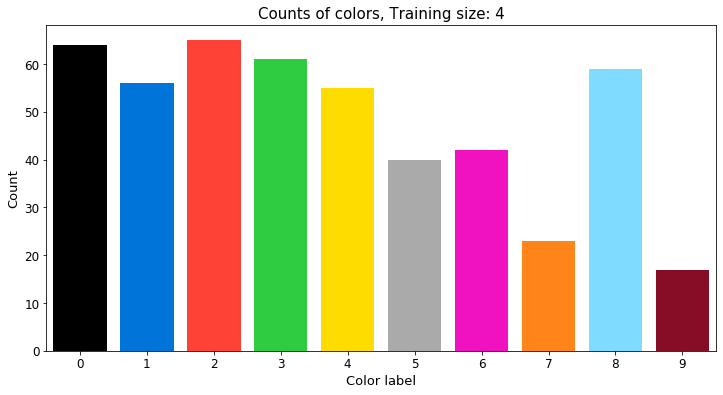

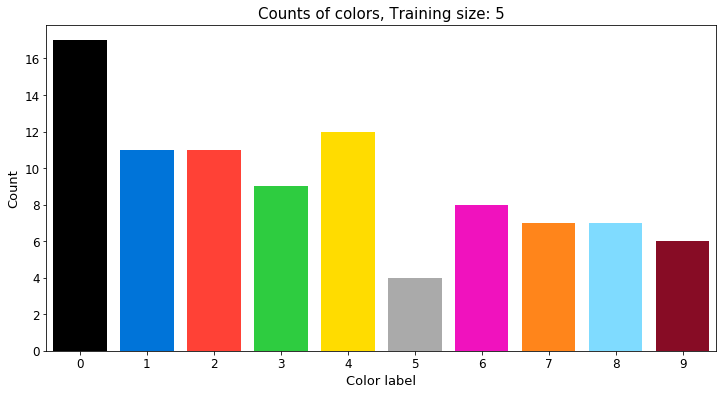

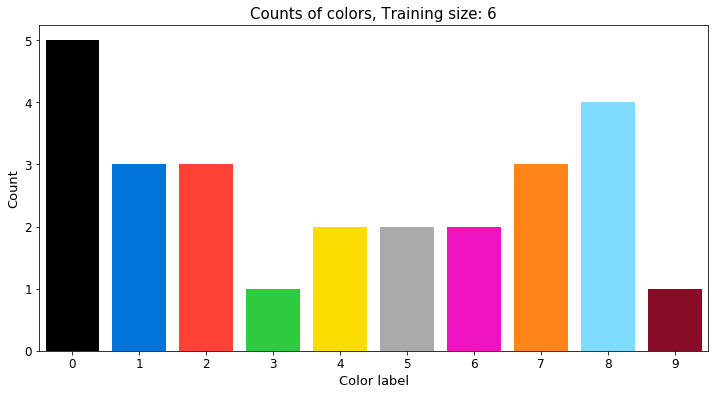

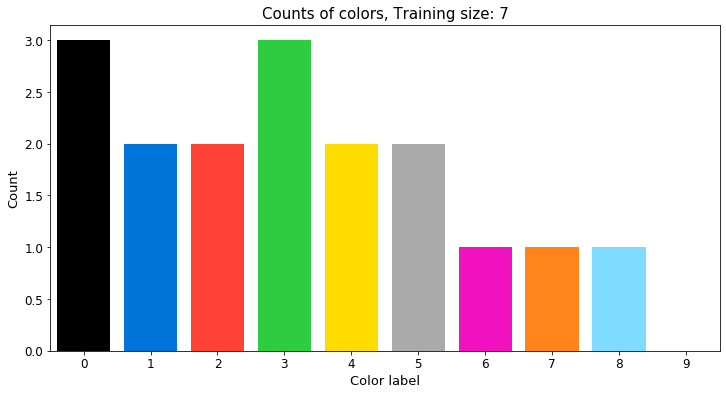

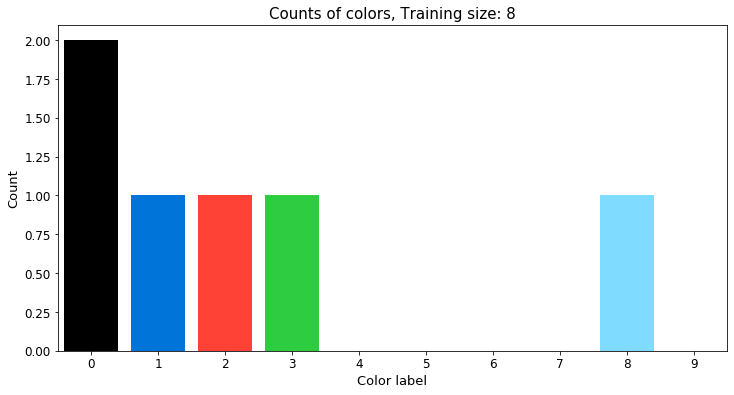

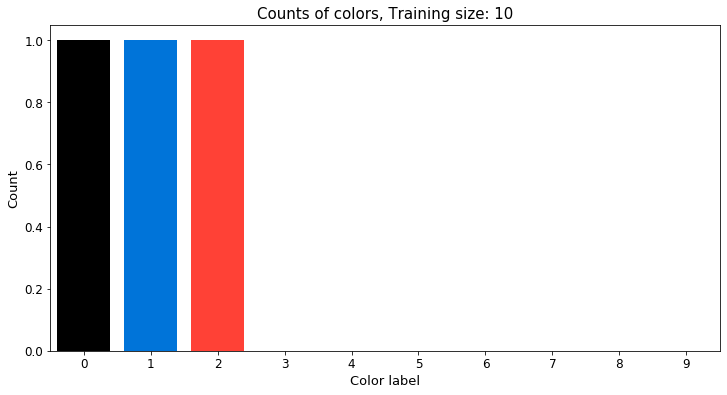

In [7]:
import itertools
from collections import Counter

groups = task_summary.groupby('num_train')

color_dict = {0:'#000000', 1:'#0074D9', 2:'#FF4136', 3:'#2ECC40', 4:'#FFDC00',
              5:'#AAAAAA', 6:'#F012BE', 7:'#FF851B', 8:'#7FDBFF', 9:'#870C25'}

for name, group in groups: 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    
    colors_list = group['unique_colors'].values.tolist()
    combined_colors = list(itertools.chain.from_iterable(colors_list))
    color_counts = Counter(combined_colors)
    
    used_colors = [color_dict.get(x) for x in color_counts.keys()]
    ax.bar(color_counts.keys(), color_counts.values(), color=used_colors)
    ax.set_title(f'Counts of colors, Training size: {name}', size = 15)
    ax.set_xlabel('Color label', size=13)
    ax.set_ylabel('Count', size=13)
    ax.set_xlim(-0.5, 9.5)
    plt.xticks(np.arange(0, 10, 1.0))
    
    ax.tick_params(axis='both', which='major', labelsize=12)

Below are a list of the observations: 

- a color of black occurs in every single group, this is because black likely denotes empty space within the patterns. 
- the red and lightblue colors appear to occur most frequently in groups 2 and 3. 
- the groups 2,3, and 4 appear to follow a similar distribution regarding their use of colors. The patterns appear to peak at 2, 6, and 8. 
- no other noticeable patterns between groups

## Model Input Dimensions

In [8]:
def num_of_unique(lst):
    return len(set(lst))

task_summary['unique_input_widths'] = task_summary.train_input_widths.apply(num_of_unique)
task_summary['unique_input_heights'] = task_summary.train_input_heights.apply(num_of_unique)
task_summary['unique_output_widths'] = task_summary.train_output_widths.apply(num_of_unique)
task_summary['unique_output_heights'] = task_summary.train_output_heights.apply(num_of_unique)

task_summary[['unique_input_widths', 'unique_input_heights']].values.max()

6

Based on the maximum number of unique values in the width and height columns, the model must be chosen to be able to accept at least 6 varying input dimensions. 

## Pattern Analysis

In order to gain a better understanding of how to choose a model/algorithm, we will manually analyze 5 different training sets

In [9]:
# functions to plot grids

def plot_grid(grid, ax, title, size):
    ax.imshow(grid, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(grid))])
    ax.set_xticks([x-0.5 for x in range(1+len(grid[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title, size=size)
    
def plot_task_pairs(pairs, task_type):
    if task_type == 'Test': 
        title_size = 15
        
        pair = pairs[0]
        task_input = pair['input']
        task_output = pair['output']

        fig, axs = plt.subplots(ncols=2, figsize=(12, 7))

        plot_grid(task_input, axs[0], task_type + ' Input', title_size)
        plot_grid(task_output, axs[1], task_type + ' Output', title_size)
        
    elif task_type == 'Train': 
        title_size = 10
        num_train = len(pairs)
        
        fig, axs = plt.subplots(ncols=num_train, nrows=2, figsize=(15, 7))
        
        for i in range(num_train): 
            task_input = pairs[i]['input']
            task_output = pairs[i]['output']
            
            plot_grid(task_input, axs[0, i], task_type + ' Input ' + str(i), title_size) 
            plot_grid(task_output, axs[1, i], task_type + ' Output ' + str(i), title_size) 
            
def plot_train_test(sample_task):
    sample_task_str = str(sample_task)
    print(sample_task_str + '\n')

    with open(sample_task_str, 'r') as f:
        task = json.load(f)

        train = task['train']
        test = task['test']

        plot_task_pairs(train, 'Train')
        plot_task_pairs(test, 'Test')

In [10]:
from pathlib import Path

training_path = Path('../Data/training')
training_tasks = training_path.glob('**/*.json')

cmap = colors.ListedColormap(
   ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

..\Data\training\007bbfb7.json



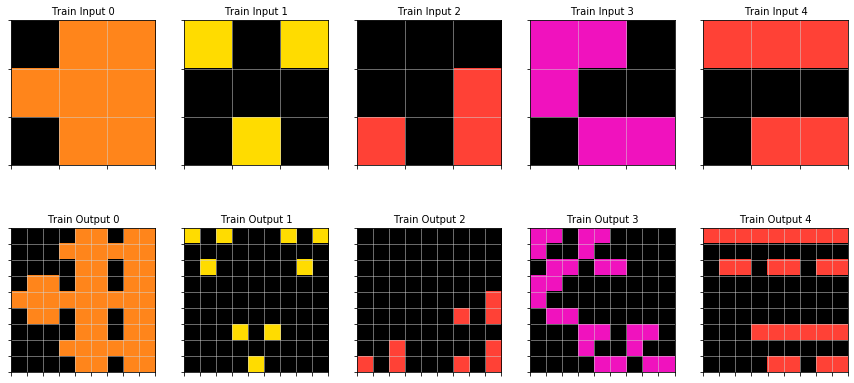

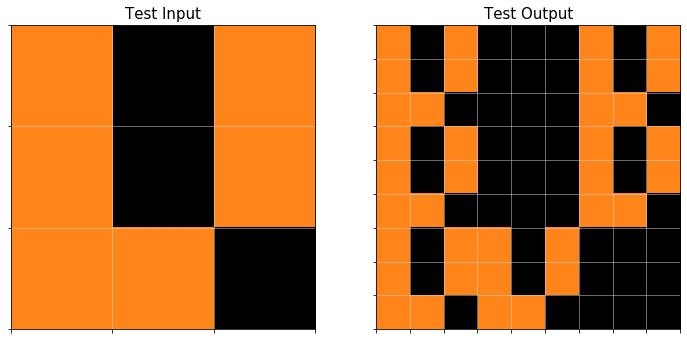

In [11]:
sample_task = next(training_tasks)

plot_train_test(sample_task)

### Task: 007bbfb7.json

From the training samples, it appears that the input is a 3x3 grid while the output is a 9x9 grid. The original pattern in the input is repeated in each of the 3x3 subgrids within the output grid at the locations denoted by the colored squares in the input grid. The color used in the input is the same color used in the output. 

..\Data\training\00d62c1b.json



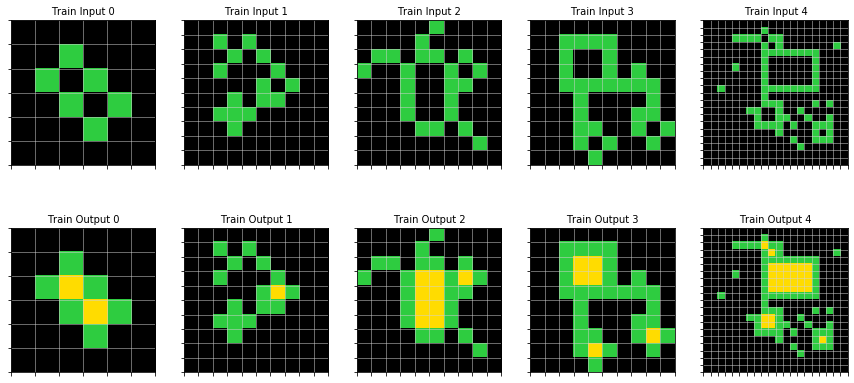

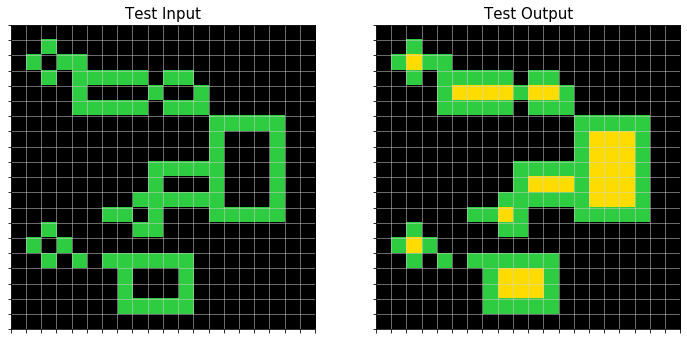

In [12]:
sample_task = next(training_tasks)

plot_train_test(sample_task)

### Task: 00d62c1b.json

Color all grid squares enclosed by green squares with yellow squares. 

..\Data\training\017c7c7b.json



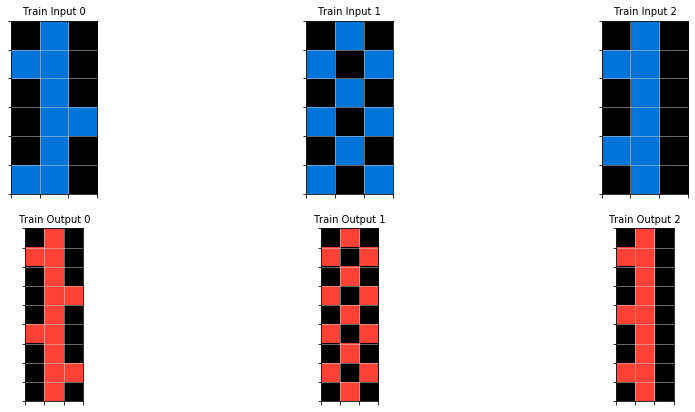

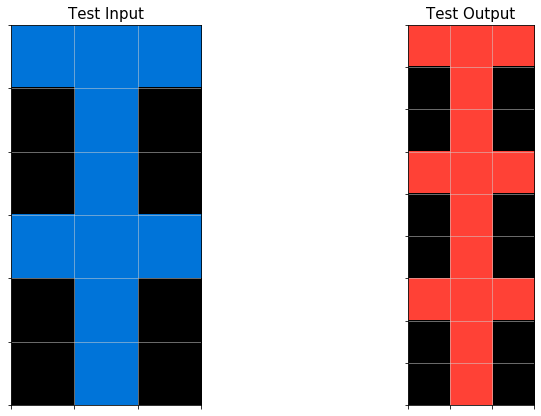

In [13]:
sample_task = next(training_tasks)

plot_train_test(sample_task)

### Task: 017c7c7b.json

Extend the pattern downward another three rows. If the pattern is alternating, use the correct alternation as the the pattern is extended. Color of input is blue, color of ouptut is red. 

..\Data\training\025d127b.json



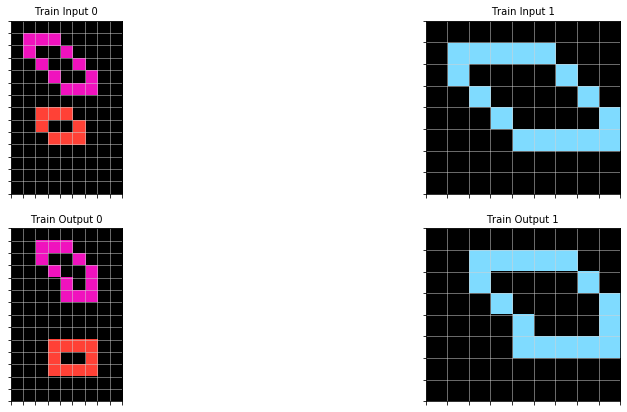

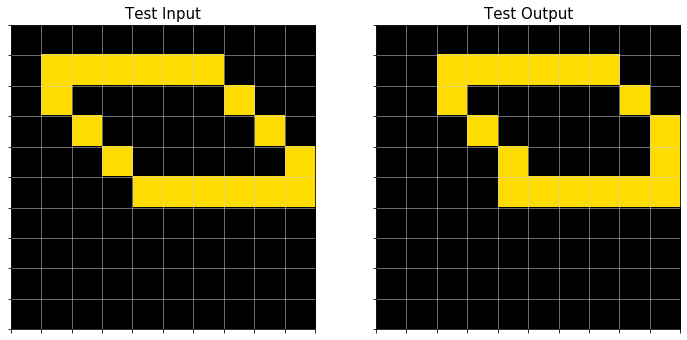

In [14]:
sample_task = next(training_tasks)

plot_train_test(sample_task)

### Task: 025d127b.json

Move lower section of pattern to the left by a single col. Remove empty column to the right. Color of output is the same as color of input. 

..\Data\training\045e512c.json



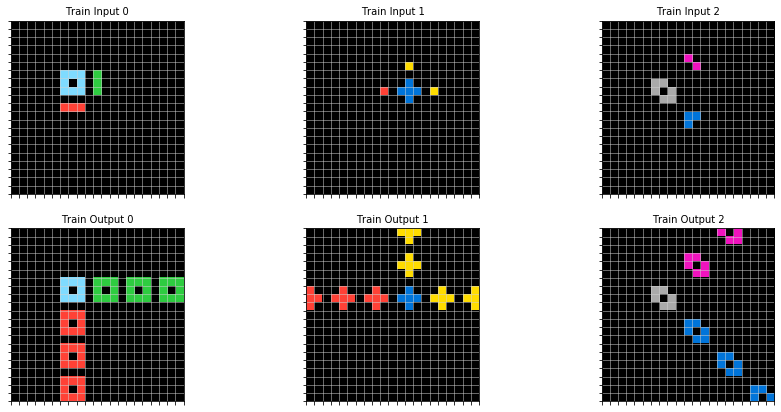

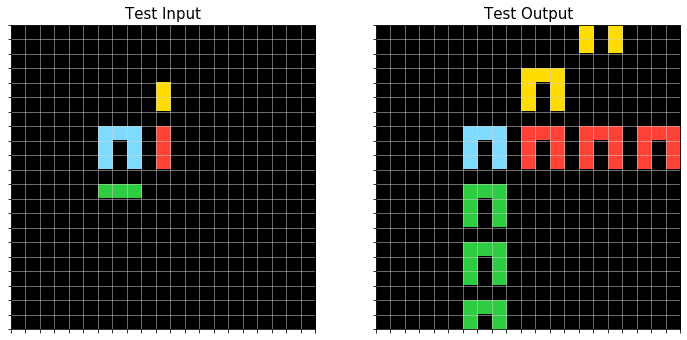

In [15]:
sample_task = next(training_tasks)

plot_train_test(sample_task)

### Task: 045e512c.json

Extend base pattern using color denoted by squares surrounding base pattern. Number of empty squares between repetitions is denoted by how far the surrounding square is from the base pattern. The base pattern is repeated at the surrounding square, starting from the opposite end. For example, if the surrounding is located at the right side of the base pattern, the surrounding square will form the left side of the base pattern. 

## Scatter Plot of Input and Output Dimensions  

Finally, we plot the dimensions of the inputs and outputs and determine if there are any common trends between the inputs and outputs. 

In [34]:
# Note: we add random noise to jitter the data and make overlapping data points more visible.

input_widths_lists = task_summary.train_input_widths.values.tolist()
input_widths = list(itertools.chain.from_iterable(input_widths_lists)) 
input_widths = input_widths + 0.5 * np.random.rand(len(input_widths))

input_heights_lists = task_summary.train_input_heights.values.tolist()
input_heights = list(itertools.chain.from_iterable(input_heights_lists))
input_heights = input_heights + 0.5 * np.random.rand(len(input_heights)) 

output_widths_lists = task_summary.train_output_widths.values.tolist()
output_widths = list(itertools.chain.from_iterable(output_widths_lists)) 
output_widths = output_widths + 0.5 * np.random.rand(len(output_widths))

output_heights_lists = task_summary.train_output_heights.values.tolist()
output_heights = list(itertools.chain.from_iterable(output_heights_lists)) 
output_heights = output_heights + 0.5 * np.random.rand(len(output_heights))

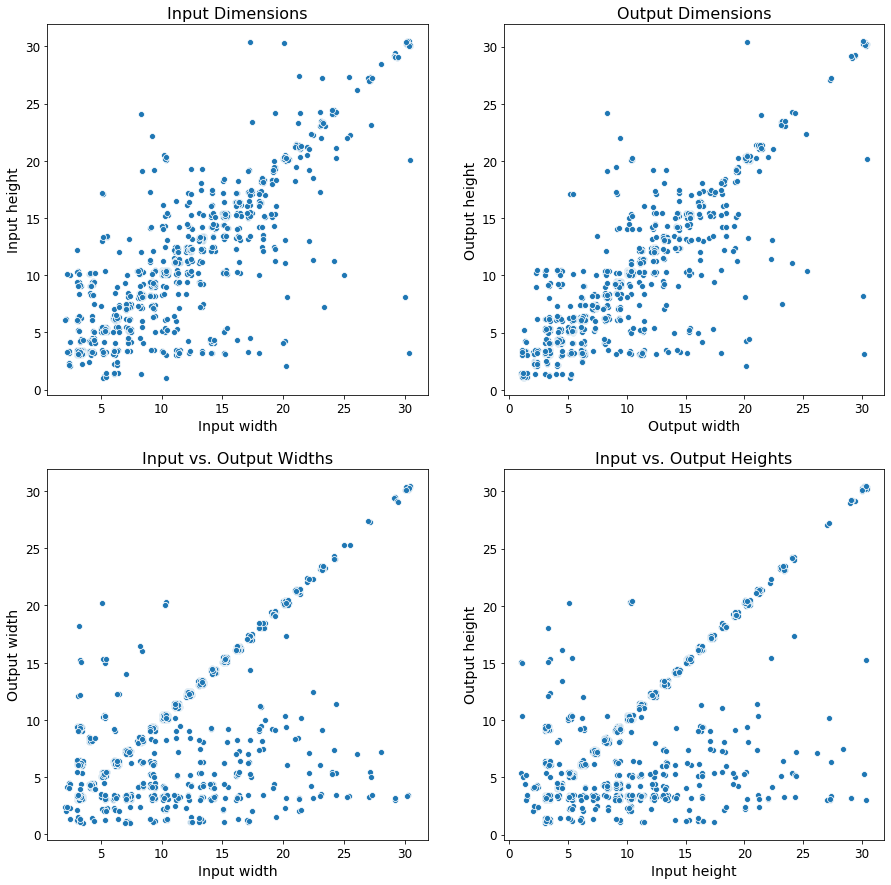

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

sns.scatterplot(x=input_widths, y=input_heights, ax=ax1)
sns.scatterplot(x=output_widths, y=output_heights, ax=ax2)
sns.scatterplot(x=input_widths, y=output_widths, ax=ax3)
sns.scatterplot(x=input_heights, y=output_heights, ax=ax4)


ax1.set_title('Input Dimensions', size=16)
ax1.set_xlabel('Input width', size=14)
ax1.set_ylabel('Input height', size=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.set_title('Output Dimensions', size=16)
ax2.set_xlabel('Output width', size=14)
ax2.set_ylabel('Output height', size=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax3.set_title('Input vs. Output Widths', size=16)
ax3.set_xlabel('Input width', size=14)
ax3.set_ylabel('Output width', size=14)
ax3.tick_params(axis='both', which='major', labelsize=12)

ax4.set_title('Input vs. Output Heights', size=16)
ax4.set_xlabel('Input height', size=14)
ax4.set_ylabel('Output height', size=14)
ax4.tick_params(axis='both', which='major', labelsize=12)

We notice that the majority of the inputs and outputs dimensions are or close to being square. Additionally, between the inputs and outputs, there are clearly some tasks where the dimensions do not change. Of the tasks where the dimensions do change, its clear that input widths and input heights tend to be larger than their respective output dimensions. 